Loaded 99422 rows with 48 columns.
            player_name player_color     opponent_name  player_elo  \
0  Kupreichik, Viktor D        white      Tal, Mikhail      2540.0   
1           Keres, Paul        white      Tal, Mikhail         NaN   
2          Tal, Mikhail        white  Keene, Raymond D         NaN   
3        Klovans, Janis        white      Tal, Mikhail         NaN   
4          Tal, Mikhail        white        Benko, Pal         NaN   

         date  eco eco_family  \
0  1979-12-01  B97          B   
1  1961-10-16  D30          D   
2  1964-01-10  B15          B   
3  1951-01-01  C52          C   
4  1959-01-01  B27          A   

                                        opening_name player_type  game_id  \
0  Sicilian Defense: Najdorf Variation, Poisoned ...         NaN        0   
1      Queen's Gambit Declined: Capablanca Variation         NaN        1   
2                 Caro-Kann Defense: Alekhine Gambit    Activist        2   
3     Italian Game: Evans Gambit, Sok

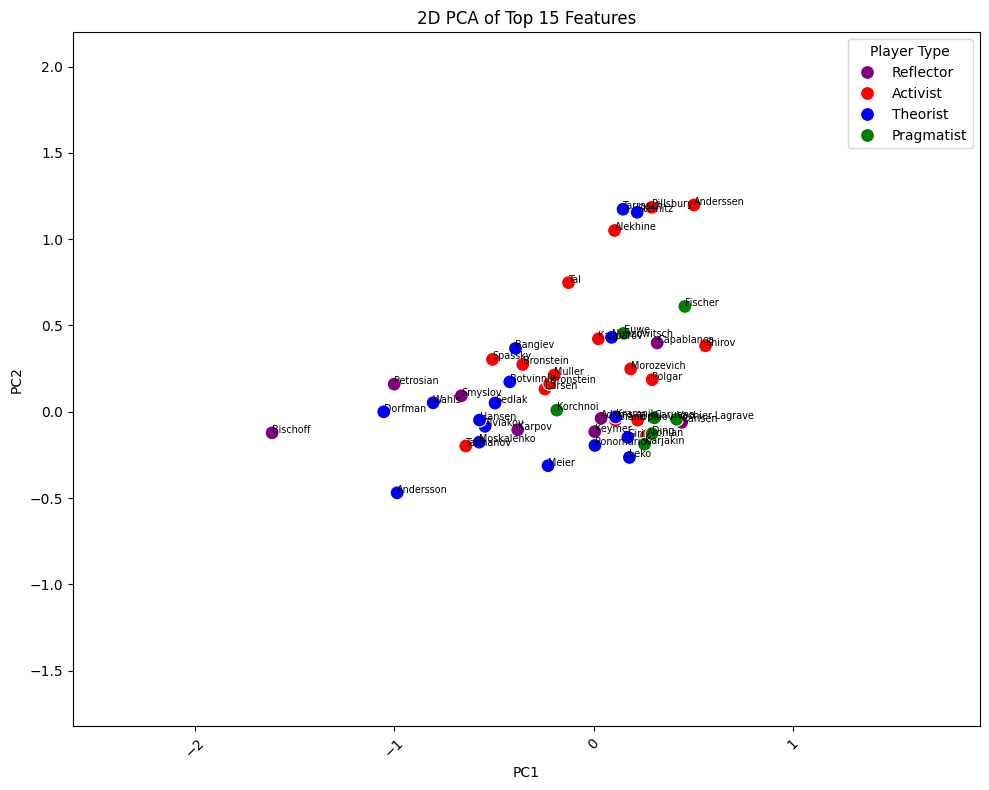

PCA (all features) explained variance ratios: [0.38323531 0.23960099 0.08299346]
PCA components:
Component 1:
eco_numeric_avg            0.103732
player_elo                 0.132290
minor_piece_development   -0.217454
queen_development         -0.113644
queen_lifetime            -0.192308
castle_move               -0.181519
material_changes          -0.015174
piece_mobility_avg         0.028992
pawn_structure_changes    -0.214662
pawn_control               0.123266
center_control_avg        -0.056964
space_advantage           -0.056199
king_safety                0.056741
vulnerability_spikes       0.007847
check_frequency           -0.120139
critical_performance       0.197066
weighted_alignment         0.250371
accuracy                   0.182502
opening_accuracy           0.264158
middlegame_accuracy        0.225739
endgame_accuracy           0.265947
avg_eval_change           -0.179829
sacrifice_count           -0.204427
prophylactic_frequency    -0.102369
brilliant_count           

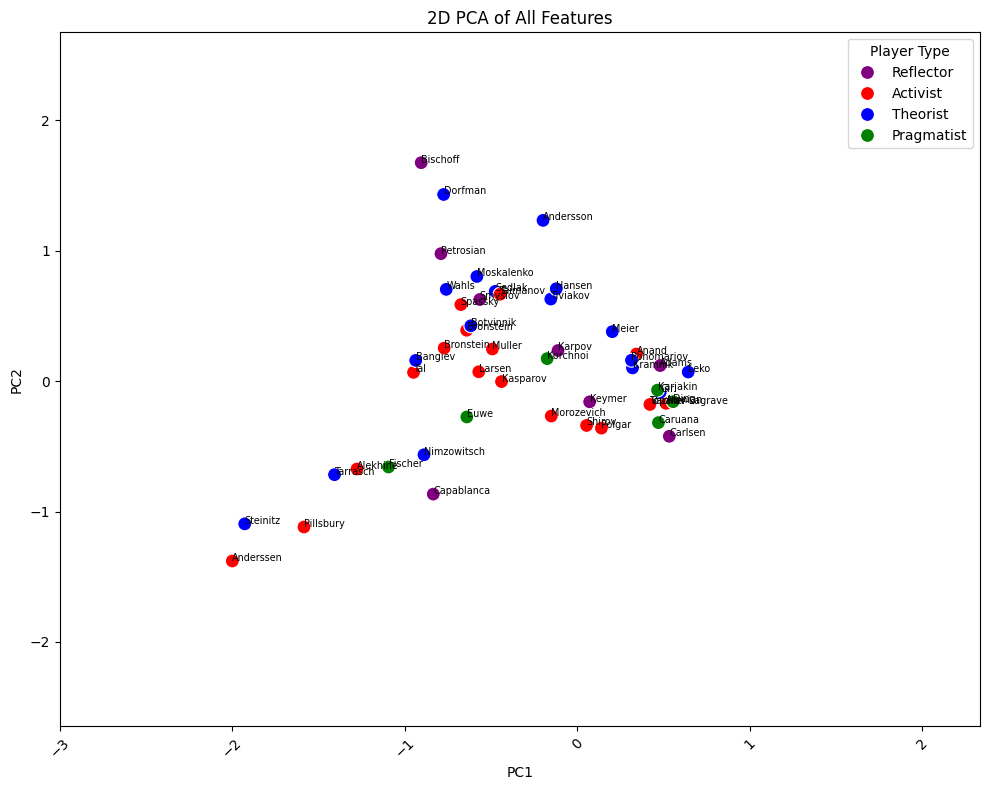

AUC for Activist: 0.7222222222222223
AUC for Pragmatist: 0.5384615384615384
AUC for Reflector: 0.3846153846153846
AUC for Theorist: 0.76
Mean AUC Score (Decision Boundary Score): 0.6013247863247864


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Step 1. Aggregate Game-Level Data to Player Level
# -------------------------------
def aggregate_player_data(players_df, min_games=3):
    """
    Aggregate game-level data into a player-level DataFrame.
    Only players with at least `min_games` games are included.
    Averages are computed for numeric features.
    'None' player types are replaced with 'Unknown'.
    """
    # Identify players with enough games
    game_counts = players_df['player_name'].value_counts()
    players_with_enough_games = game_counts[game_counts >= min_games].index.tolist()
    print(f"Found {len(players_with_enough_games)} players with at least {min_games} games.")

    # Filter to these players
    filtered_df = players_df[players_df['player_name'].isin(players_with_enough_games)].copy()

    # Columns that we will ignore for numeric aggregation
    ignore_cols = ['player_name', 'player_color', 'opponent_name', 'game_id', 'result', 'player_type', 'date', 'total_moves']
    numeric_cols = [col for col in filtered_df.columns
                    if col not in ignore_cols and pd.api.types.is_numeric_dtype(filtered_df[col])]
    

    
    
    
    # impute missing values based on the mean of each player
    filtered_df[numeric_cols] = filtered_df.groupby('player_name')[numeric_cols].transform(lambda x: x.fillna(x.mean()))
    
    
    

    aggregated_data = []

    for player in players_with_enough_games:
        player_games = filtered_df[filtered_df['player_name'] == player]
        # Get the first non-NaN player_type if available, default to 'Unknown'
        if 'player_type' in player_games.columns:
            p_type_series = player_games['player_type'].dropna()
            p_type = p_type_series.iloc[0] if not p_type_series.empty else 'Unknown' # Changed None to 'Unknown'
        else:
            p_type = 'Unknown' # Changed None to 'Unknown'

        
        
        
        player_stats = {
            'player_name': player,
            'player_type': p_type,
            'eco_numeric_avg': 0.5,  # Default value for missing data
            'num_games': len(player_games)
            
        }
        player_ecos = player_games['eco'].dropna()
        
        if not player_ecos.empty:
            # Convert each ECO code to a numerical value
            # Format is a letter (A-E) followed by two digits (00-99)
            # We'll convert to a value between 0-1
            
            # First, convert the letter to a value (A=0, B=0.2, C=0.4, D=0.6, E=0.8)
            letter_values = {'A': 0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8}
            
            def eco_to_numeric(eco_code):
                try:
                    if pd.isna(eco_code) or not isinstance(eco_code, str) or len(eco_code) < 3:
                        return None
                    letter = eco_code[0]
                    number = int(eco_code[1:3])
                    # Letter contributes the main value (0, 0.2, 0.4, 0.6, 0.8)
                    # Number contributes 0-0.199 (scaled from 00-99)
                    return letter_values.get(letter, 0) + (number / 500)
                except:
                    return None
            
            # Convert all ECO codes to numeric and calculate average
            numeric_ecos = [eco_to_numeric(eco) for eco in player_ecos]
            numeric_ecos = [x for x in numeric_ecos if x is not None]
            
            if numeric_ecos:
                player_stats['eco_numeric_avg'] = sum(numeric_ecos) / len(numeric_ecos)
            else:
                player_stats['eco_numeric_avg'] = 0.5  # Default value for missing data
        else:
            player_stats['eco_numeric_avg'] = 0.5  # Default value for 
        # Compute averages for each numeric feature
        for col in numeric_cols:
            player_stats[col] = player_games[col].mean()
        aggregated_data.append(player_stats)

    agg_df = pd.DataFrame(aggregated_data)
    return agg_df

# -------------------------------
# Step 2. Select Best Features using RandomForest Importance
# -------------------------------
def select_best_features(agg_df, n_features=15, importance_threshold=0.1):
    """
    Select best numeric features using RandomForestClassifier importance
    with 'player_type' as the target.
    """
    metadata = ['player_name', 'player_type', 'num_games']
    print(f"Selecting best features from {len(agg_df)} players with {len(agg_df.columns)} columns.")
    print(f"All features: {agg_df.columns.tolist()}")
    numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]


    # drop unknown players
    agg_df = agg_df[agg_df['player_type'] != 'Unknown']
    # reset index to avoid KeyError when accessing rows by position
    agg_df = agg_df.reset_index(drop=True)
   
    X = agg_df[numeric_cols]
    y = agg_df['player_type']
    



    # Encode player_type as numeric
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Impute and scale
    # Impute missing values based on the mean of each player
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train RandomForest classifier
    rf = RandomForestClassifier(n_estimators=2500, random_state=42)
    rf.fit(X_scaled, y_encoded)

    importances = rf.feature_importances_
    importance_series = pd.Series(importances, index=numeric_cols)

    # Normalize importances to the maximum value
    importance_series = importance_series / importance_series.max()

    # Select features above the importance threshold
    selected = importance_series[importance_series > importance_threshold].index.tolist()

    # If more than desired n_features, choose the top n_features based on importance
    if len(selected) > n_features:
        selected = importance_series.sort_values(ascending=False).index[:n_features].tolist()

    print("Selected features:", selected)
    return selected

# -------------------------------
# Step 3. Apply PCA to Selected Features
# -------------------------------
def apply_pca(agg_df, features, n_components=3):
    """
    Scale the selected features, apply PCA and return the transformed data.
    """
    X = agg_df[features]
    # Impute missing values based on the mean of each player
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()

    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA explained variance ratios: {pca.explained_variance_ratio_}")

    # Print the components with feature names
    print("PCA components:")
    for i, component in enumerate(pca.components_):
        feature_weights = pd.Series(component, index=features)
        print(f"Component {i+1}:")
        print(feature_weights)

    return X_pca, pca

def apply_pca_all_features(agg_df, n_components=2):
    """
    Apply PCA to all numeric features (without any feature selection)
    for a 2D visualization.
    """
    metadata = ['player_name', 'player_type', 'num_games']
    numeric_cols = [col for col in agg_df.columns 
                    if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]
    
    X = agg_df[numeric_cols]
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)
    
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    print(f"PCA (all features) explained variance ratios: {pca.explained_variance_ratio_}")

    # Print the components with feature names
    print("PCA components:")
    for i, component in enumerate(pca.components_):
        feature_weights = pd.Series(component, index=numeric_cols)
        print(f"Component {i+1}:")
        print(feature_weights)
    return X_pca, pca

# -------------------------------
# Step 4. Visualize 2D PCA Result using Seaborn
# -------------------------------
def visualize_2d_pca(agg_df, X_pca_2d, title='2D PCA of Top 15 Features'):
    """
    Visualize 2D PCA result using a scatter plot.
    Points are colored by player_type and labeled by player_name.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_2d[:, 0],
        'PC2': X_pca_2d[:, 1],
        'player_type': agg_df['player_type'], # Should now contain 'Unknown' instead of None
        'player_name': agg_df['player_name']
    })
    
    # Filter out unknown players AFTER creating the dataframe with all the data
    pca_df = pca_df[pca_df['player_type'] != 'Unknown']
    
    # hide activist 
    # pca_df = pca_df[pca_df['player_type'] != 'Activist']
    
    # hide pragmatist
    # pca_df = pca_df[pca_df['player_type'] != 'Pragmatist']
    
    # hide reflector
    # pca_df = pca_df[pca_df['player_type'] != 'Reflector']
    
    # hide theorist
    # pca_df = pca_df[pca_df['player_type'] != 'Theorist']
    
    # Reset the index to avoid KeyError when accessing rows by position
    pca_df = pca_df.reset_index(drop=True)

    plt.figure(figsize=(10, 8))
    # Define the palette, using 'Unknown' as the key for gray
    palette = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray' # Changed None key to 'Unknown'
    }
    ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='player_type',
                         palette=palette, s=100)

    # Add labels for each point
    for line in range(0,pca_df.shape[0]):
         player_name = pca_df.player_name[line]
         if ', ' in player_name:
             last_name = player_name.split(', ')[0]
             ax.text(pca_df.PC1[line], pca_df.PC2[line], last_name, horizontalalignment='left', size='x-small', color='black')
         else:
             ax.text(pca_df.PC1[line], pca_df.PC2[line], player_name, horizontalalignment='left', size='x-small', color='black')

    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Player Type')
    plt.xlim(X_pca_2d[:, 0].min() - 1, X_pca_2d[:, 0].max() + 1)
    plt.ylim(X_pca_2d[:, 1].min() - 1, X_pca_2d[:, 1].max() + 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -------------------------------
# Step 5. Create Interactive 3D PCA Visualization using Plotly Express
# -------------------------------
def visualize_3d_pca(agg_df, X_pca_3d):
    """
    Create an interactive 3D scatter plot of the PCA result using Plotly Express.
    Points are colored by player_type.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_3d[:, 0],
        'PC2': X_pca_3d[:, 1],
        'PC3': X_pca_3d[:, 2],
        'player_type': agg_df['player_type'], # Should now contain 'Unknown' instead of None
        'player_name': agg_df['player_name']
    })

    # Define the color map, using 'Unknown' as the key for gray
    color_map = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray'  # Changed None key to 'Unknown'
    }

    fig = px.scatter_3d(
        pca_df,
        x='PC1', y='PC2', z='PC3',
        color='player_type',
        hover_data=['player_name'],
        color_discrete_map=color_map,
        title='Interactive 3D PCA of Top 15 Features'
    )
    fig.update_traces(marker=dict(size=5))
    fig.show()

# -------------------------------
# Step 6. Decision Boundary Score (AUC)
# -------------------------------
def calculate_decision_boundary_score(agg_df):
    """
    Calculates the Area Under the ROC Curve (AUC) for a RandomForestClassifier
    predicting player_type.  Uses the selected features from the
    select_best_features function.  Prints AUC for each class and the mean AUC.
    """

    # Prepare data
    agg_df = agg_df.copy()
    
    # Skip unknown players
    agg_df = agg_df[agg_df['player_type'] != 'Unknown']
    
    le = LabelEncoder()
    agg_df['player_type'] = le.fit_transform(agg_df['player_type'])  # Numerical labels

    # Select features (using the same logic as before)
    metadata = ['player_name', 'player_type', 'num_games']
    numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]

    X = agg_df[numeric_cols]
    y = agg_df['player_type']
    
    # Impute missing values based on the mean of each player
    X = X.groupby(agg_df['player_name']).transform(lambda x: x.fillna(x.mean()))

    # Impute and Scale
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Train RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=5000, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = rf_classifier.predict_proba(X_test)

    # Calculate AUC (one-vs-rest for multiclass)
    auc_scores = {}
    for i in range(len(le.classes_)):
        try:
            auc = roc_auc_score(y_test == i, y_pred_proba[:, i])
            auc_scores[le.inverse_transform([i])[0]] = auc
            print(f"AUC for {le.inverse_transform([i])[0]}: {auc}")
        except ValueError as e:
            class_name = le.inverse_transform([i])[0]
            print(f"ValueError calculating AUC for class {class_name}: {e}")
            auc_scores[class_name] = 0.5  # Assign a neutral value if AUC cannot be computed

    mean_auc = np.mean(list(auc_scores.values()))

    print(f"Mean AUC Score (Decision Boundary Score): {mean_auc}")
    return mean_auc


# -------------------------------
# Main Function
# -------------------------------
def main():
    # Load the game-level data
    input_file = 'player_centric_data.csv'  # Adjust the file path as necessary
    df = pd.read_csv(input_file)
    print(f"Loaded {len(df)} rows with {len(df.columns)} columns.")
    print(df.head())

    # Aggregate to player level (using a minimum game threshold, e.g., 100)
    # This will now replace None player_types with 'Unknown'
    agg_df = aggregate_player_data(df, min_games=100)

    # Select best features based on importance
    selected_features = select_best_features(agg_df, n_features=15, importance_threshold=0.1)

    # Apply PCA for 3 components
    X_pca, pca_model = apply_pca(agg_df, selected_features, n_components=3)

    # Visualize the first 2 components (2D PCA)
    # The palette now correctly maps 'Unknown' to gray
    visualize_2d_pca(agg_df, X_pca[:, :2])

    # Create an interactive 3D PCA visualization
    # The color map now correctly maps 'Unknown' to gray
    # visualize_3d_pca(agg_df, X_pca)
    
    
    # apply PCA to all features for 2D visualization
    X_pca_all, pca_model_all = apply_pca_all_features(agg_df, n_components=3)
    visualize_2d_pca(agg_df, X_pca_all[:, :2], title='2D PCA of All Features')
    # Create an interactive 3D PCA visualization for all features
    # visualize_3d_pca(agg_df, X_pca_all)

    # Calculate and print decision boundary score (AUC)
    calculate_decision_boundary_score(agg_df)

if __name__ == "__main__":
    main()


In [2]:
70733745037505244

70733745037505244

Loaded 99422 rows with 48 columns.
Found 96 players with at least 100 games.

Assigned player types for 1 players from provided lists
Assigned eras for 48 players

Player Era Categorization:
  Unknown Era: 48 players
  Computer Age: 30 players
  Pre-Computer Age: 18 players

Player Types in Computer Age:
  Theorist: 14 players
  Activist: 7 players
  Reflector: 5 players
  Pragmatist: 4 players

Player Types in Pre-Computer Age:
  Activist: 8 players
  Theorist: 4 players
  Pragmatist: 3 players
  Reflector: 3 players

Player Types in Unknown Era:
  Unknown: 46 players
  Activist: 2 players

Selected features: ['great_count', 'opening_accuracy', 'opening_novelty_score', 'material_changes', 'queen_lifetime', 'player_elo', 'space_advantage', 'center_control_avg', 'check_frequency', 'top2_3_move_alignment', 'sacrifice_count', 'top_move_alignment', 'endgame_length', 'good_moves', 'queen_development']


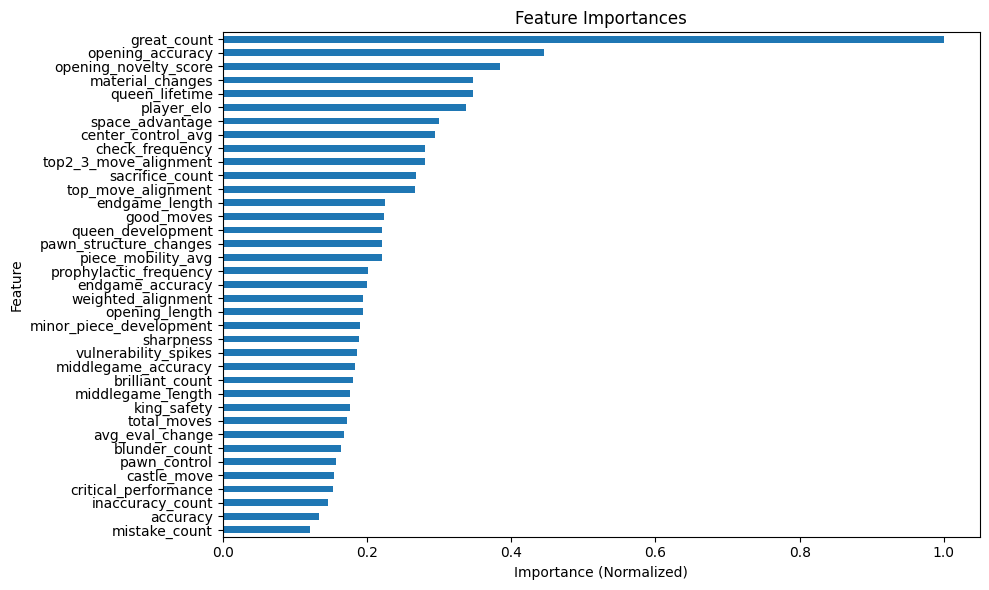

PCA explained variance ratios: [0.38529566 0.30000405 0.10463962]


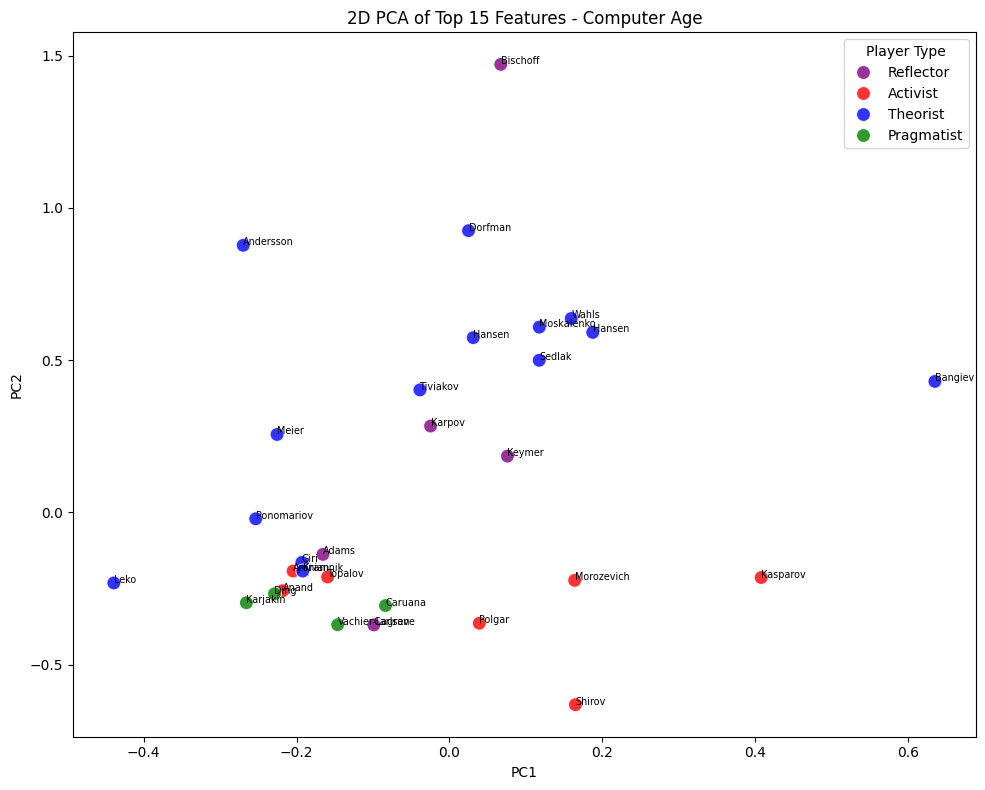

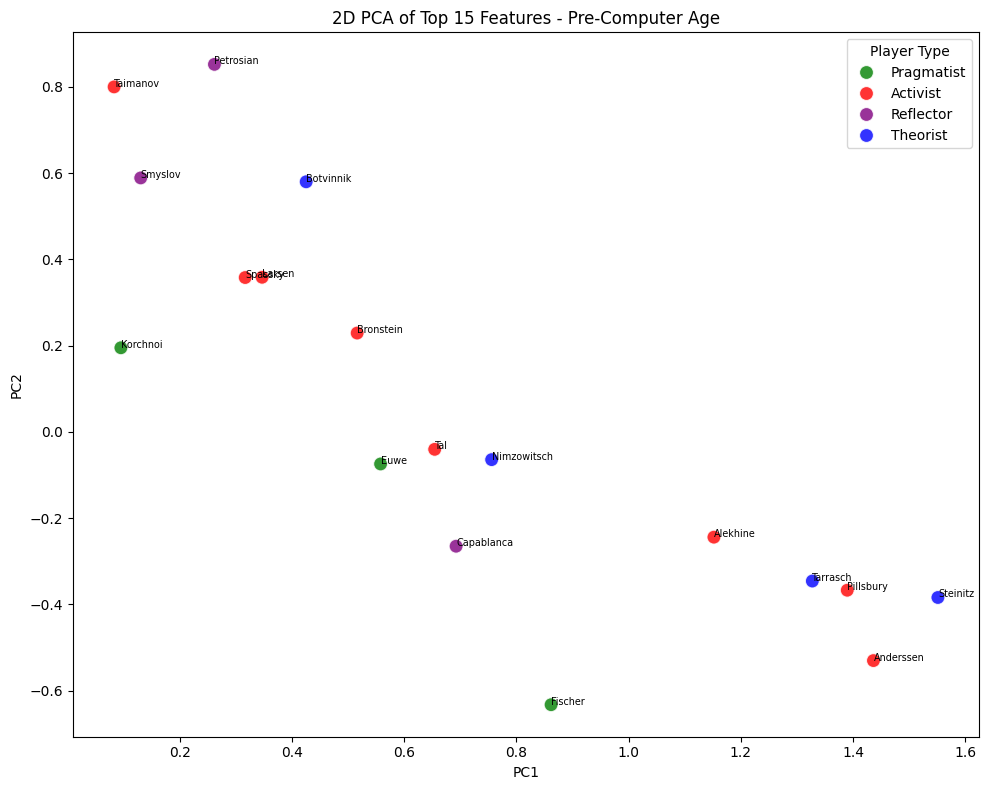

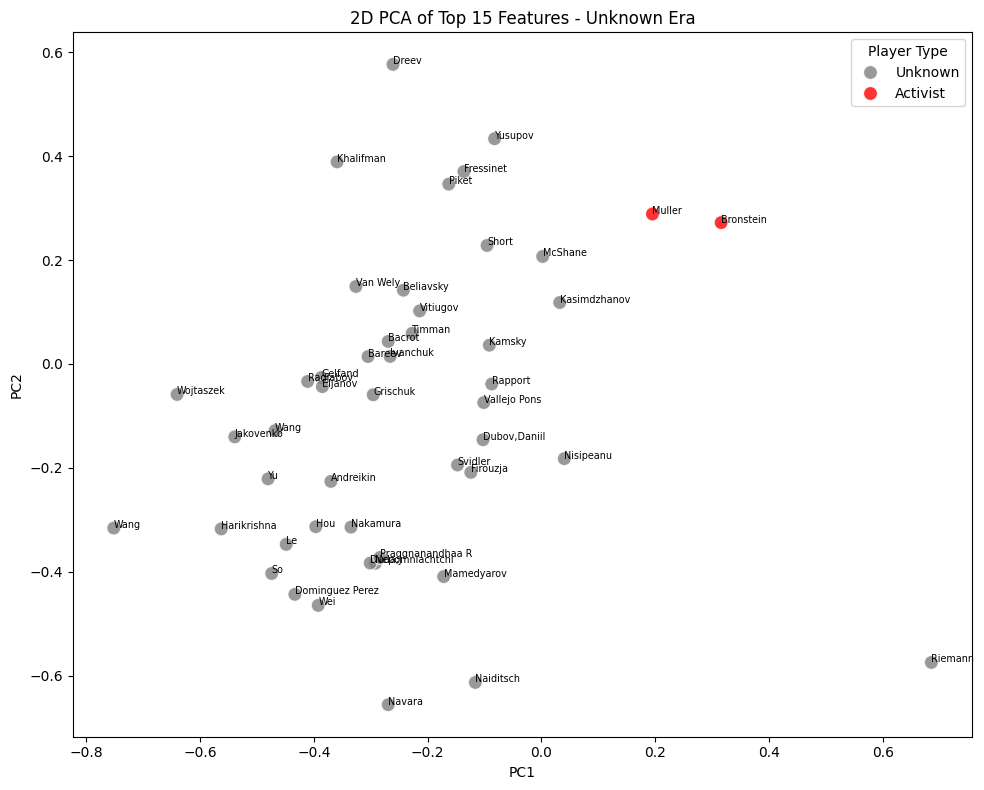

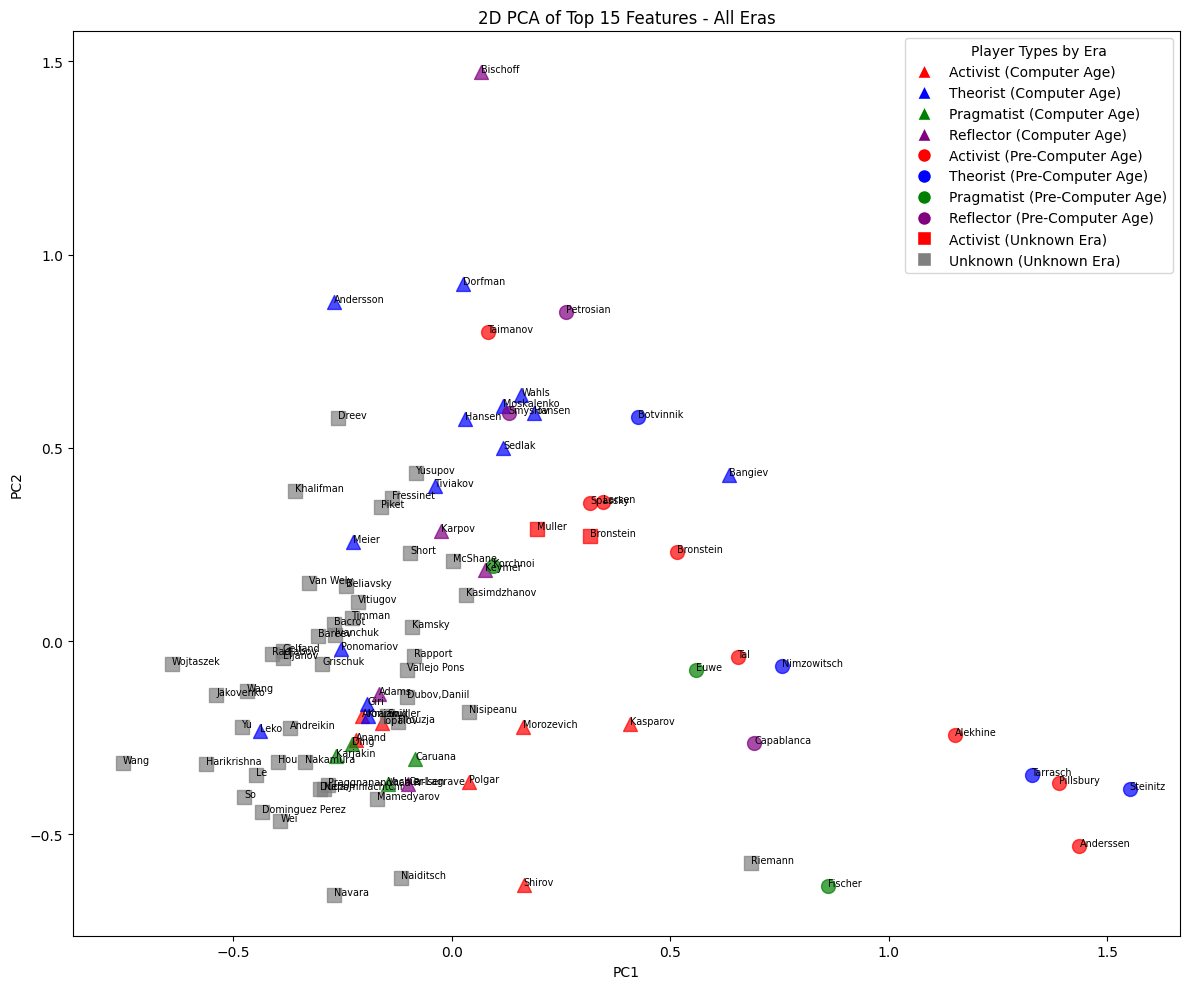


Calculating Decision Boundary Score for Computer Age:
  AUC for Activist: 1.0000
  AUC for Pragmatist: 0.4000
  AUC for Reflector: 0.2000
  AUC for Theorist: 1.0000
  Mean AUC Score for Computer Age: 0.6500

Calculating Decision Boundary Score for Pre-Computer Age:
  AUC for Activist: 0.2500
  AUC for Pragmatist: 0.0000
  AUC for Reflector: nan
  AUC for Theorist: 0.3333
  Mean AUC Score for Pre-Computer Age: nan

Calculating Decision Boundary Score for Unknown Era:
  AUC for Activist: nan
  AUC for Unknown: nan
  Mean AUC Score for Unknown Era: nan

Calculating Combined Decision Boundary Score:
  AUC for Activist: 0.6875
  AUC for Pragmatist: 0.2222
  AUC for Reflector: 0.7407
  AUC for Theorist: 0.6848
  AUC for Unknown: 0.9143
Combined Mean AUC Score: 0.6499


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Define Known Player Types by Era
# -------------------------------
activist_pre_computer = [
    "Alekhine", "Tal", "Spassky", "Pillsbury",
    "Anderssen", "Bronstein, David", "Larsen", "Taimanov"
]

activist_computer_age = [
    "Kasparov", "Anand", "Shirov", "Morozevich",
    "Topalov", "Aronian", "Polgar", "Müller"
]

theorist_pre_computer = [
    "Steinitz", "Botvinnik", "Tarrasch", "Nimzowitsch"
]

theorist_computer_age = [
    "Kramnik", "Leko", "Giri", "Meier", "Andersson",
    "Sedlak", "Tiviakov", "Ponomariov", "Wahls",
    "Moskalenko", "Dorfman", "Bangiev", "Hansen"
]

reflector_pre_computer = [
    "Capablanca", "Smyslov", "Petrosian"
]

reflector_computer_age = [
    "Karpov", "Carlsen", "Adams, Michael", "Keymer", "Bischoff"
]

pragmatist_pre_computer = [
    "Fischer", "Euwe", "Korchnoi"
]

pragmatist_computer_age = [
    "Caruana", "Ding", "Karjakin", "Vachier-Lagrave"
]

# -------------------------------
# Step 1. Aggregate Game-Level Data to Player Level
# -------------------------------
def aggregate_player_data(players_df, min_games=3):
    """
    Aggregate game-level data into a player-level DataFrame.
    Only players with at least `min_games` games are included.
    Averages are computed for numeric features.
    'None' player types are replaced with 'Unknown'.
    """
    # Identify players with enough games
    game_counts = players_df['player_name'].value_counts()
    players_with_enough_games = game_counts[game_counts >= min_games].index.tolist()
    print(f"Found {len(players_with_enough_games)} players with at least {min_games} games.")

    # Filter to these players
    filtered_df = players_df[players_df['player_name'].isin(players_with_enough_games)].copy()

    # Columns that we will ignore for numeric aggregation
    ignore_cols = ['player_name', 'player_color', 'opponent_name', 'game_id', 'result', 'player_type']
    numeric_cols = [col for col in filtered_df.columns
                    if col not in ignore_cols and pd.api.types.is_numeric_dtype(filtered_df[col])]

    aggregated_data = []

    for player in players_with_enough_games:
        # print(f"{player}")
        player_games = filtered_df[filtered_df['player_name'] == player]
        # Get the first non-NaN player_type if available, default to 'Unknown'
        if 'player_type' in player_games.columns:
            p_type_series = player_games['player_type'].dropna()
            p_type = p_type_series.iloc[0] if not p_type_series.empty else 'Unknown'
        else:
            p_type = 'Unknown'

        player_stats = {
            'player_name': player,
            'player_type': p_type,
            'num_games': len(player_games)
        }
        # Compute averages for each numeric feature
        for col in numeric_cols:
            player_stats[col] = player_games[col].mean()
        aggregated_data.append(player_stats)

    agg_df = pd.DataFrame(aggregated_data)
    return agg_df

# -------------------------------
# Step 2. Categorize Players into Pre-Computer and Computer Age Eras
# -------------------------------
def categorize_players_by_era(agg_df):
    """
    Categorize players into "Pre-Computer Age" and "Computer Age" based on
    their presence in the known player lists.
    """
    # Add era column, default to 'Unknown Era'
    agg_df['era'] = 'Unknown Era'
    
    # For tracking assignment stats
    assigned_type_count = 0
    assigned_era_count = 0
    
    # Categorize players by type and era
    for idx, player in agg_df.iterrows():
        player_name = player['player_name']
        original_type = player['player_type']
        
        # Check all known player categories
        if any(name in player_name for name in activist_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Activist'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in activist_computer_age):
            agg_df.at[idx, 'player_type'] = 'Activist'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in theorist_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Theorist'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in theorist_computer_age):
            agg_df.at[idx, 'player_type'] = 'Theorist'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in reflector_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Reflector'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in reflector_computer_age):
            agg_df.at[idx, 'player_type'] = 'Reflector'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in pragmatist_pre_computer):
            agg_df.at[idx, 'player_type'] = 'Pragmatist'
            agg_df.at[idx, 'era'] = 'Pre-Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        elif any(name in player_name for name in pragmatist_computer_age):
            agg_df.at[idx, 'player_type'] = 'Pragmatist'
            agg_df.at[idx, 'era'] = 'Computer Age'
            if original_type == 'Unknown':
                assigned_type_count += 1
            assigned_era_count += 1
            
        else:
            # Try to extract birth/death years from player names if we didn't match a known player
            import re
            birth_year = None
            
            # Look for years in parentheses in the player name
            year_pattern = r'\((\d{4})[-–](\d{4}|\?{4}|\d{0})\)'
            match = re.search(year_pattern, player_name)
            
            if match:
                # Found birth-death years pattern
                birth_year = int(match.group(1))
                
                # Assume a player's prime playing years are ~20-30 years after birth
                prime_playing_year = birth_year + 30
                if prime_playing_year < 1990:  # 1990 as computer age threshold
                    agg_df.at[idx, 'era'] = 'Pre-Computer Age'
                    assigned_era_count += 1
                else:
                    agg_df.at[idx, 'era'] = 'Computer Age'
                    assigned_era_count += 1
    
    # Summary of the categorization
    print(f"\nAssigned player types for {assigned_type_count} players from provided lists")
    print(f"Assigned eras for {assigned_era_count} players")
    
    era_counts = agg_df['era'].value_counts()
    print("\nPlayer Era Categorization:")
    for era, count in era_counts.items():
        print(f"  {era}: {count} players")
    
    # Count player types in each era
    for era in agg_df['era'].unique():
        era_df = agg_df[agg_df['era'] == era]
        print(f"\nPlayer Types in {era}:")
        type_counts = era_df['player_type'].value_counts()
        for player_type, count in type_counts.items():
            print(f"  {player_type}: {count} players")
    
    return agg_df

# -------------------------------
# Step 3. Select Best Features using RandomForest Importance
# -------------------------------
def select_best_features(agg_df, n_features=15, importance_threshold=0.1):
    """
    Select best numeric features using RandomForestClassifier importance
    with 'player_type' as the target.
    """
    metadata = ['player_name', 'player_type', 'num_games', 'era']
    numeric_cols = [col for col in agg_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df[col])]

    X = agg_df[numeric_cols]
    y = agg_df['player_type']

    # Encode player_type as numeric
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Impute and scale
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train RandomForest classifier
    rf = RandomForestClassifier(n_estimators=1500, random_state=42)
    rf.fit(X_scaled, y_encoded)

    importances = rf.feature_importances_
    importance_series = pd.Series(importances, index=numeric_cols)

    # Normalize importances to the maximum value
    importance_series = importance_series / importance_series.max()

    # Select features above the importance threshold
    selected = importance_series[importance_series > importance_threshold].index.tolist()

    # If more than desired n_features, choose the top n_features based on importance
    if len(selected) > n_features:
        selected = importance_series.sort_values(ascending=False).index[:n_features].tolist()

    print("\nSelected features:", selected)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    importance_series.sort_values(ascending=True).plot(kind='barh')
    plt.title('Feature Importances')
    plt.xlabel('Importance (Normalized)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return selected

# -------------------------------
# Step 4. Apply PCA to Selected Features
# -------------------------------
def apply_pca(agg_df, features, n_components=3):
    """
    Scale the selected features, apply PCA and return the transformed data.
    """
    X = agg_df[features]
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()

    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA explained variance ratios: {pca.explained_variance_ratio_}")
    return X_pca, pca

# -------------------------------
# Step 5. Visualize 2D PCA Result using Seaborn 
# -------------------------------
def visualize_2d_pca(agg_df, X_pca_2d):
    """
    Visualize 2D PCA result with separate plots for each era, and a combined view.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_2d[:, 0],
        'PC2': X_pca_2d[:, 1],
        'player_type': agg_df['player_type'],
        'player_name': agg_df['player_name'],
        'era': agg_df['era'],
        'num_games': agg_df['num_games']
    })

    # Define color palette for player types
    palette = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray'
    }
    
    # Create separate plots for each era
    eras = pca_df['era'].unique()
    
    for era in eras:
        era_df = pca_df[pca_df['era'] == era]
        
        if len(era_df) < 2:  # Skip if not enough players
            print(f"Skipping visualization for {era} (insufficient data)")
            continue
            
        plt.figure(figsize=(10, 8))
        ax = sns.scatterplot(data=era_df, x='PC1', y='PC2', hue='player_type',
                         palette=palette, s=100, alpha=0.8)

        # Add labels for each point
        for i, row in era_df.iterrows():
            player_name = row['player_name']
            if ', ' in player_name:
                last_name = player_name.split(', ')[0]
                ax.text(row['PC1'], row['PC2'], last_name, 
                       horizontalalignment='left', size='x-small', color='black')
            else:
                ax.text(row['PC1'], row['PC2'], player_name, 
                       horizontalalignment='left', size='x-small', color='black')

        plt.title(f'2D PCA of Top 15 Features - {era}')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(title='Player Type')
        plt.tight_layout()
        plt.show()

    # Create combined visualization with different markers for each era
    plt.figure(figsize=(12, 10))
    
    # Define markers for eras
    markers = {'Pre-Computer Age': 'o', 'Computer Age': '^', 'Unknown Era': 's'}
    
    # Create a custom legend elements list
    from matplotlib.lines import Line2D
    legend_elements = []
    
    # Plot each era and player type combination separately
    for era in eras:
        for p_type in palette.keys():
            # Get the subset of data for this era and player type
            subset = pca_df[(pca_df['era'] == era) & (pca_df['player_type'] == p_type)]
            if not subset.empty:
                plt.scatter(subset['PC1'], subset['PC2'], 
                           color=palette[p_type], 
                           marker=markers[era],
                           s=100, 
                           alpha=0.7,
                           label=f"{p_type} ({era})")
                
                # Add this combination to the legend
                legend_elements.append(
                    Line2D([0], [0], marker=markers[era], color='w', 
                          markerfacecolor=palette[p_type], markersize=10, 
                          label=f"{p_type} ({era})")
                )
    
    # Add player name labels
    for i, row in pca_df.iterrows():
        player_name = row['player_name']
        if ', ' in player_name:
            last_name = player_name.split(', ')[0]
            plt.text(row['PC1'], row['PC2'], last_name, 
                   horizontalalignment='left', size='x-small', color='black')
        else:
            plt.text(row['PC1'], row['PC2'], player_name, 
                   horizontalalignment='left', size='x-small', color='black')
    
    plt.title('2D PCA of Top 15 Features - All Eras')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(handles=legend_elements, loc='best', title="Player Types by Era")
    plt.tight_layout()
    plt.show()

# -------------------------------
# Step 6. Create Interactive 3D PCA Visualization
# -------------------------------
def visualize_3d_pca(agg_df, X_pca_3d):
    """
    Create interactive 3D scatter plots of the PCA result using Plotly Express.
    """
    pca_df = pd.DataFrame({
        'PC1': X_pca_3d[:, 0],
        'PC2': X_pca_3d[:, 1],
        'PC3': X_pca_3d[:, 2],
        'player_type': agg_df['player_type'],
        'player_name': agg_df['player_name'],
        'era': agg_df['era'],
        'num_games': agg_df['num_games']
    })

    # Define color map for player types
    color_map = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Pragmatist': 'green',
        'Reflector': 'purple',
        'Unknown': 'gray'
    }

    # Create separate plots for each era
    for era in pca_df['era'].unique():
        era_df = pca_df[pca_df['era'] == era]
        
        if len(era_df) < 2:  # Skip if not enough players
            print(f"Skipping 3D visualization for {era} (insufficient data)")
            continue
        
        fig = px.scatter_3d(
            era_df,
            x='PC1', y='PC2', z='PC3',
            color='player_type',
            hover_data=['player_name', 'num_games'],
            color_discrete_map=color_map,
            title=f'3D PCA of Player Features - {era}'
        )
        fig.update_traces(marker=dict(size=5))
        fig.show()
    
    # Create a combined visualization with both color and symbol
    fig = px.scatter_3d(
        pca_df,
        x='PC1', y='PC2', z='PC3',
        color='player_type',
        symbol='era',  # Use era for different marker symbols
        hover_data=['player_name', 'num_games', 'era'],
        color_discrete_map=color_map,
        title='3D PCA of Player Features - All Eras Combined'
    )
    fig.update_traces(marker=dict(size=5))
    fig.show()

# -------------------------------
# Step 7. Calculate Decision Boundary Quality (AUC)
# -------------------------------
def calculate_decision_boundary_score(agg_df):
    """
    Calculate the Area Under the ROC Curve (AUC) for predicting player_type.
    """
    # Calculate separately for each era
    for era in agg_df['era'].unique():
        era_df = agg_df[agg_df['era'] == era].copy()
        
        # Skip if too few samples or not enough player types
        if len(era_df) < 10 or era_df['player_type'].nunique() <= 1:
            print(f"Skipping AUC calculation for {era} (insufficient data)")
            continue
            
        print(f"\nCalculating Decision Boundary Score for {era}:")
        
        # Encode player types
        le = LabelEncoder()
        era_df['player_type'] = le.fit_transform(era_df['player_type'])
        
        # Define features
        metadata = ['player_name', 'player_type', 'num_games', 'era']
        numeric_cols = [col for col in era_df.columns if col not in metadata and pd.api.types.is_numeric_dtype(era_df[col])]
        
        X = era_df[numeric_cols]
        y = era_df['player_type']
        
        # Prepare the data
        imputer = SimpleImputer(strategy='mean')
        scaler = MinMaxScaler()
        X_imputed = imputer.fit_transform(X)
        X_scaled = scaler.fit_transform(X_imputed)
        
        # Use stratified sampling to maintain class distribution
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X_scaled, y, test_size=0.2, random_state=42, stratify=y
            )
            
            # Train RandomForest and get predictions
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X_train, y_train)
            y_pred_proba = rf.predict_proba(X_test)
            
            # Calculate AUC for each class
            auc_scores = []
            for i in range(len(le.classes_)):
                if i < y_pred_proba.shape[1]:
                    try:
                        auc = roc_auc_score(y_test == i, y_pred_proba[:, i])
                        class_name = le.inverse_transform([i])[0]
                        print(f"  AUC for {class_name}: {auc:.4f}")
                        auc_scores.append(auc)
                    except ValueError as e:
                        print(f"  Error calculating AUC for class {i}: {e}")
            
            if auc_scores:
                mean_auc = np.mean(auc_scores)
                print(f"  Mean AUC Score for {era}: {mean_auc:.4f}")
        
        except Exception as e:
            print(f"  Could not calculate AUC for {era}: {e}")
    
    # Calculate for all players combined
    print("\nCalculating Combined Decision Boundary Score:")
    
    # Prepare data
    agg_df_copy = agg_df.copy()
    le = LabelEncoder()
    agg_df_copy['player_type'] = le.fit_transform(agg_df_copy['player_type'])

    # Select features
    metadata = ['player_name', 'player_type', 'num_games', 'era']
    numeric_cols = [col for col in agg_df_copy.columns if col not in metadata and pd.api.types.is_numeric_dtype(agg_df_copy[col])]

    X = agg_df_copy[numeric_cols]
    y = agg_df_copy['player_type']

    # Process the data
    imputer = SimpleImputer(strategy='mean')
    scaler = MinMaxScaler()
    X_imputed = imputer.fit_transform(X)
    X_scaled = scaler.fit_transform(X_imputed)

    # Train/test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )

    # Train and evaluate
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_proba = rf.predict_proba(X_test)

    # Calculate AUC for each class
    auc_scores = []
    for i in range(len(le.classes_)):
        try:
            auc = roc_auc_score(y_test == i, y_pred_proba[:, i])
            class_name = le.inverse_transform([i])[0]
            print(f"  AUC for {class_name}: {auc:.4f}")
            auc_scores.append(auc)
        except ValueError as e:
            print(f"  Error for class {i}: {e}")

    if auc_scores:
        mean_auc = np.mean(auc_scores)
        print(f"Combined Mean AUC Score: {mean_auc:.4f}")

# -------------------------------
# Main Function
# -------------------------------
def main():
    # Load the game-level data
    input_file = 'player_centric_data.csv'
    df = pd.read_csv(input_file)
    print(f"Loaded {len(df)} rows with {len(df.columns)} columns.")

    # Aggregate to player level
    agg_df = aggregate_player_data(df, min_games=100)
    
    # Categorize players into eras
    agg_df = categorize_players_by_era(agg_df)

    # Select best features
    selected_features = select_best_features(agg_df, n_features=15, importance_threshold=0.1)

    # Apply PCA
    X_pca, pca_model = apply_pca(agg_df, selected_features, n_components=3)

    # Visualize PCA results
    visualize_2d_pca(agg_df, X_pca[:, :2])
    visualize_3d_pca(agg_df, X_pca)

    # Calculate decision boundary quality
    calculate_decision_boundary_score(agg_df)

if __name__ == "__main__":
    main()